# Correlate datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import math

In [3]:
import brsflufight_nerc2  as bff2

## Prepare data

In [9]:
data_sets = bff2.load_data_files()

Data is loaded into a `DataGroup` which is simply a dictionary which exposes the method `get_country`.

In [5]:
country = 'United Kingdom'

d_uk = data_sets.get_country(country)

Success: historical_GHG_Sectors_GCP
Success: historical_GHG_Sectors_PIK
Success: historical_GHG_Sectors_UNFCCC
Success: mobility_apple
Failed: United Kingdom not in mobility_citymapper
Success: mobility_google
Success: uk_energy_daily


In [10]:
d_uk['uk_energy_yearly'] = d_uk['uk_energy_daily'].groupby(pd.Grouper(freq='1Y')).mean()

## Choose analysis datasets

In [28]:
gas = "CO2"
cols_GCP = d_uk['historical_GHG_Sectors_GCP'].columns
cols_GCP = [s for s in cols_GCP if f"({gas})" in s]

to_correlate = {
    'uk_energy_yearly': ['oil', 'ccgt', 'coal', 'demand'],
    'historical_GHG_Sectors_GCP': cols_GCP,
    'historical_GHG_Sectors_PIK': ['Energy (KYOTOGHG)', 'Energy (CO2)', 'Energy (N2O)']
}

In [45]:
def mask_dateindex(df, df_mask):
    return (
        (df.index >= df_mask.index.min()) 
        & (df.index <= df_mask.index.max()) 
    )

def correlate(
    selector:dict,
    data_sets:[dict, bff2.DataSet],
    main_compare:str,
    min_year=None,
    max_year=None,
):
    corrs = []
    for dataset in [c for c in selector if c != main_compare]:
        ref_mask = mask_dateindex(data_sets[main_compare], data_sets[dataset])
        targ_mask = mask_dateindex(data_sets[dataset], data_sets[main_compare])
        corrs.append(
            pd.merge_asof(
                data_sets[main_compare].loc[ref_mask, selector[main_compare]], 
                data_sets[dataset].loc[targ_mask, selector[dataset]], 
                left_index=True, right_index=True, direction='nearest'
            ).corr().loc[selector[main_compare], selector[dataset]]
        )
    return corrs

In [47]:
for corr in correlate(
    selector=to_correlate,
    data_sets=d_uk,
    main_compare='uk_energy_yearly',
):
    display(corr.style.background_gradient().set_precision(2))

,Bunkers (CO2),Cement (CO2),Coal (CO2),Gas (CO2),Gas flaring (CO2),Oil (CO2),Total fossil fuels and cement (CO2)
oil,nan,-0.69,0.88,-0.28,-0.68,-0.82,0.88
ccgt,nan,-0.20,-0.31,0.48,-0.12,0.55,-0.23
coal,nan,-0.51,0.88,-0.61,-0.54,-0.85,0.82
demand,nan,-0.63,0.92,-0.66,-0.61,-0.92,0.86


,Energy (KYOTOGHG),Energy (CO2),Energy (N2O)
oil,0.85,0.86,0.64
ccgt,-0.02,-0.02,-0.00
coal,0.74,0.74,0.65
demand,0.80,0.80,0.72


In [10]:
energy_demand = d_uk['uk_energy_daily'][['oil', 'ccgt', 'coal', 'demand']]
# energy_ghg = d_uk['historical_GHG_Sectors_PIK']['Energy (KYOTOGHG)']

gas = "CO2"
GHG_data = 'historical_GHG_Sectors_GCP'

cols = d_uk['historical_GHG_Sectors_GCP'].columns
cols_GHG = [s for s in cols if f"({gas})" in s]
energy_ghg = d_uk[GHG_data][cols_GHG]



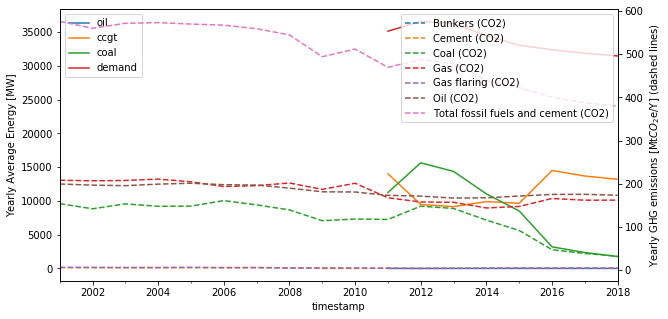

In [19]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax1_args = {}
ax2_args = {}
if energy_demand_yearly.shape[1] == 1 and energy_ghg.shape[1] == 1:
    ax1_args = {'color':"C0"}
    ax2_args = {'color':"C1"}
energy_demand_yearly.plot(
    y=[c for c in energy_demand_yearly],
    ax=axs, 
    label=[c for c in energy_demand_yearly],
    **ax1_args
)
ax2 = axs.twinx()
energy_ghg[energy_ghg.index > "2000"].plot(ax=ax2, label="GHG emissions", linestyle='--', **ax2_args)

axs.set_ylabel('Yearly Average Energy [MW]', **ax1_args)
ax2.set_ylabel('Yearly GHG emissions [Mt$CO_2$e/Y] (dashed lines)', **ax2_args)
axs.legend()
ax2.legend()

In [35]:
merged = pd.merge_asof(
    energy_ghg[energy_ghg.index > "2012"], 
    energy_demand_yearly, 
    left_index=True, right_index=True, direction='nearest')

In [36]:
merged.corr().style.background_gradient().set_precision(2)

,Coal (CO2),Gas (CO2),Oil (CO2),oil,ccgt,coal,demand
Coal (CO2),1.00,-0.65,-0.94,0.91,-0.74,0.95,0.99
Gas (CO2),-0.65,1.00,0.69,-0.30,0.51,-0.63,-0.68
Oil (CO2),-0.94,0.69,1.00,-0.84,0.63,-0.86,-0.93
oil,0.91,-0.30,-0.84,1.00,-0.62,0.84,0.86
ccgt,-0.74,0.51,0.63,-0.62,1.00,-0.91,-0.79
coal,0.95,-0.63,-0.86,0.84,-0.91,1.00,0.97
demand,0.99,-0.68,-0.93,0.86,-0.79,0.97,1.00


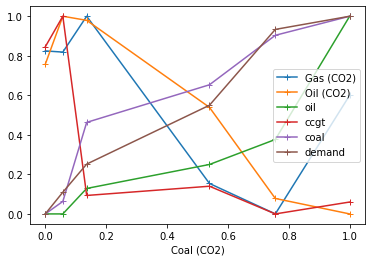

In [37]:
((merged-merged.min())/(merged.max()-merged.min())).plot(x='Coal (CO2)', marker='+')